Let's download all the dependencies that we will need.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# import k-means from clustering stage
from sklearn.cluster import KMeans

import requests # library to handle requests
import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from geopy.distance import distance # find distance between two points with latitude and longitude

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library
from folium import IFrame

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

import operator

%matplotlib inline

Fetching package metadata .............
Solving package specifications: .

# All requested packages already installed.
# packages in environment at /opt/conda/envs/DSX-Python35:
#
geopy                     1.18.1                     py_0    conda-forge
Fetching package metadata .............
Solving package specifications: .

# All requested packages already installed.
# packages in environment at /opt/conda/envs/DSX-Python35:
#
folium                    0.5.0                      py_0    conda-forge


## 1. Download Dataset

In order to categorize the recommended venues based on crime incidents, we will essentially need two datasets one which contains the venues and its latitude and longitudes cordinates and the other that contains crime incidents records along with the latitude and logitude coordinates of their occurance.

The venue data is provided by Foursquare through its explore end point, https://api.foursquare.com/v2/venues/explore which returns a list of recommended venues near Downtown Boston Massachusetts United States. Crime incident data is provided by Boston Police Department (BPD). This dataset includes set of fields focused on capturing the type of incident as well as when and where it occurred and can be accessed from https://data.boston.gov/dataset/6220d948-eae2-4e4b-8723-2dc8e67722a3/resource/12cb3883-56f5-47de-afa5-3b1cf61b257b/download/tmpfh1desjt.csv. You can replace the crime incidents data set used here with the most updated data source from the web page https://data.boston.gov/dataset/crime-incident-reports-august-2015-to-date-source-new-system/resource/12cb3883-56f5-47de-afa5-3b1cf61b257b

In [2]:
address = 'Boston, MA'

geolocator = Nominatim(user_agent="explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

CLIENT_ID = 'GD4ZTRLUGTK50T0TIIL0N5ZYR5LKQ52IKMP33TMFAHYY4IO3' # replace with your Foursquare ID
CLIENT_SECRET = '42HAM3BDY5NELNZBNJJ5T2T2FQOK1DTGJOVR0FXO1KRA1F3E' #replace with your Foursquare Secret
VERSION = '20190220' # Foursquare API version
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 10000 # define the search radius

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)

results = requests.get(url).json()["response"]['groups'][0]['items']
venues_list=[]
venues_list.append([(
            result['venue']['name'],
            result['venue']['categories'][0]['name'],
            result['venue']['location']['lat'], 
            result['venue']['location']['lng']) for result in results])
print('Venue Data successfully obtained!')

Venue Data successfully obtained!


In [3]:
!wget -q -O BostonCrimeIncidents.csv https://data.boston.gov/dataset/6220d948-eae2-4e4b-8723-2dc8e67722a3/resource/12cb3883-56f5-47de-afa5-3b1cf61b257b/download/tmpfh1desjt.csv
print('Crime Data successfully obtained!')

Crime Data successfully obtained!


### Tranform the data into a *pandas* dataframe

In [4]:
bv_df = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
bv_df.columns = ['Name','Category','Latitude','Longitude']
print(bv_df.shape)
bv_df.head()

(100, 4)


Name            Category   Latitude  Longitude
0            North End Park                Park  42.362488 -71.056477
1             Quincy Market       Historic Site  42.360095 -71.054730
2  Faneuil Hall Marketplace       Historic Site  42.359978 -71.056410
3            Sam LaGrassa's      Sandwich Place  42.356870 -71.059960
4           Saus Restaurant  Belgian Restaurant  42.361076 -71.057054

In [5]:
rawdata_df = pd.read_csv('BostonCrimeIncidents.csv')
print(rawdata_df.shape)
rawdata_df.head()

(365291, 17)


incident_number  offense_code               offense_code_group  \
0      I192014361          3831  Motor Vehicle Accident Response   
1      I192014360          3006               Medical Assistance   
2      I192014355           619                          Larceny   
3      I192014352           613                          Larceny   
4      I192014349          3006               Medical Assistance   

                     offense_description district reporting_area shooting  \
0  M/V - LEAVING SCENE - PROPERTY DAMAGE      NaN                     NaN   
1          SICK/INJURED/MEDICAL - PERSON       B3            430      NaN   
2                     LARCENY ALL OTHERS       B2            602      NaN   
3                    LARCENY SHOPLIFTING       D4            627      NaN   
4          SICK/INJURED/MEDICAL - PERSON       B2            258      NaN   

      occurred_on_date  year  month day_of_week  hour    ucr_part  \
0  2019-02-22 19:22:00  2019      2      Friday    19  Part Three   
1  2019-02-24 21:11:00  2019      2      Sunday    21  Part Three   
2  2019-02-24 20:50:00  2019      2      Sunday    20    Part One   
3  2019-02-24 20:08:00  2019      2      Sunday    20    Part One   
4  2019-02-24 20:53:00  2019      2      Sunday    20  Part Three   

           street        lat       long                     location  
0             NaN        NaN        NaN     (0.00000000, 0.00000000)  
1   BLUE HILL AVE  42.285327 -71.090962  (42.28532661, -71.09096179)  
2  HUNTINGTON AVE  42.335515 -71.100832  (42.33551534, -71.10083207)  
3     BOYLSTON ST  42.344423 -71.098331  (42.34442266, -71.09833083)  
4     VIRGINIA ST  42.316941 -71.067193  (42.31694068, -71.06719268)

We will select the relevant features of crime dataset that describe the type of crime, the place of occurrence(street and the latitude,longitude cordinates) date and year when they occurred and drop the rest 

In [6]:
bostonCIGeo_df = rawdata_df[['offense_code_group','street','occurred_on_date','year','lat','long']]

# rename the dataframe columns
bostonCIGeo_df.columns =['Offense','Street','Date','Year','Latitude','Longitude'] 

print(bostonCIGeo_df.shape)
bostonCIGeo_df.head()

(365291, 6)


Offense          Street                 Date  Year  \
0  Motor Vehicle Accident Response             NaN  2019-02-22 19:22:00  2019   
1               Medical Assistance   BLUE HILL AVE  2019-02-24 21:11:00  2019   
2                          Larceny  HUNTINGTON AVE  2019-02-24 20:50:00  2019   
3                          Larceny     BOYLSTON ST  2019-02-24 20:08:00  2019   
4               Medical Assistance     VIRGINIA ST  2019-02-24 20:53:00  2019   

    Latitude  Longitude  
0        NaN        NaN  
1  42.285327 -71.090962  
2  42.335515 -71.100832  
3  42.344423 -71.098331  
4  42.316941 -71.067193

## 2. Explore and clean the datasets

Let us inspect the venues dataset to check if there are any duplicate records for a given venue name

In [7]:
bv_df[bv_df.duplicated(['Name'],keep=False)]

Name     Category   Latitude  Longitude
11           sweetgreen  Salad Place  42.357704 -71.058713
30           sweetgreen  Salad Place  42.353943 -71.058550
34  Tatte Bakery & Cafe       Bakery  42.357904 -71.070439
63  Tatte Bakery & Cafe       Bakery  42.351667 -71.071715
84           sweetgreen  Salad Place  42.349933 -71.078625
92  Tatte Bakery & Cafe         Café  42.364978 -71.082849

Take the first duplicated record and drop the rest

In [8]:
nrec=bv_df.shape[0]
bv_df.drop_duplicates(subset=['Name'], keep='first', inplace=True)
print('{} duplictes removed'.format(nrec-bv_df.shape[0]))
bv_df.shape

4 duplictes removed


(96, 4)

Now, let us filter the crime incidents dataset to include only incidents post 2019 and drop records with null values for latitude and longitude

In [9]:
bostonCIGeo_df = bostonCIGeo_df[bostonCIGeo_df.Year >= 2019]
bostonCIGeo_df.dropna(subset=['Latitude','Longitude'], inplace=True)

bostonCIGeo_df.shape

(11752, 6)

Visualize the distributiuon of lattitude longitude features in crime incidents dataset on a scatter plot to see if there any outliers

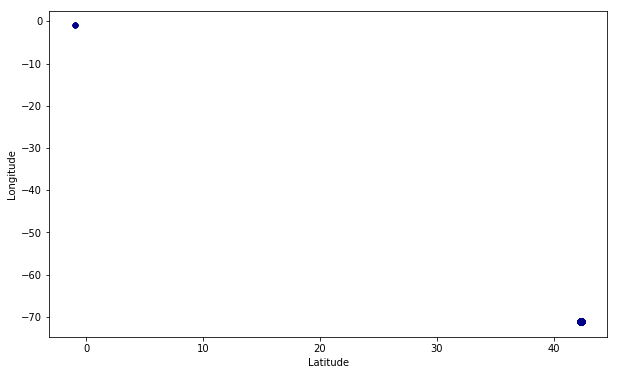

In [10]:
bostonCIGeo_df.plot(kind='scatter', x='Latitude', y='Longitude', figsize=(10, 6), color='darkblue')
plt.show()

We notice that there are outliers with -1 as value for latitude and longitude in certain records, so next lets drop such records and re-visualize the distribution

(11737, 6)


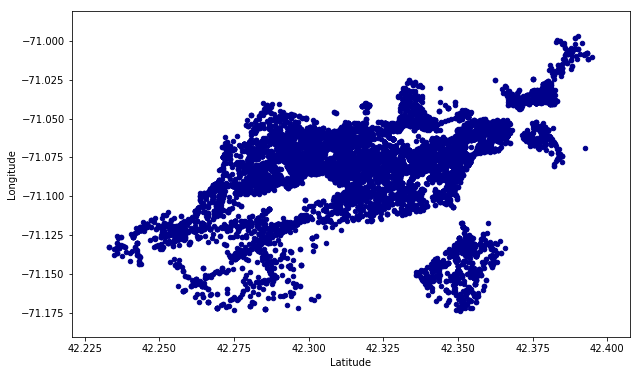

This looks good now.


In [11]:
bostonCIGeo_df = bostonCIGeo_df[bostonCIGeo_df.Latitude.astype(int) != -1]
bostonCIGeo_df = bostonCIGeo_df[bostonCIGeo_df.Longitude.astype(int) != -1]
print(bostonCIGeo_df.shape)
bostonCIGeo_df.plot(kind='scatter', x='Latitude', y='Longitude', figsize=(10, 6), color='darkblue')
plt.show()
print('This looks good now.')

Some of the values for Offense feature such as 'Investigate Property', 'Property Found', 'Medical Assistance' etc are not actually criminal actions so we discard these records. Finally only records with following crime types were selected: <br><br>
       'Larceny', 'Robbery', 'Verbal Disputes', 'Vandalism',
       'Simple Assault', 'Drug Violation', 'Bomb Hoax', 'Violations', <br>
       'Property Related Damage', 'Property Lost', 'Harassment',
       'Larceny From Motor Vehicle', 'Disorderly Conduct',<br>
       'Confidence Games', 'Aggravated Assault', 'Warrant Arrests',
       'Assembly or Gathering Violations', 'Restraining Order Violations',<br>
       'Residential Burglary', 'License Violation', 'Auto Theft',
       'Fire Related Reports', 'Fraud', 'Firearm Discovery',<br>
       'Commercial Burglary', 'Firearm Violations', 'Other Burglary',
       'Liquor Violation', 'Ballistics', 'Prostitution',<br>
       'Operating Under the Influence', 'Arson', 'Criminal Harassment',
       'Embezzlement', 'Prisoner Related Incidents', 'Counterfeiting',<br>
       'Evading Fare', 'License Plate Related Incidents', 'Homicide',
       'Offenses Against Child / Family', 'Harbor Related Incidents',<br>
       'Aircraft', 'HOME INVASION', 'Explosives'

In [12]:
bostonCIGeo_df.drop(bostonCIGeo_df[bostonCIGeo_df['Offense'].isin(['Investigate Property','Property Found','Medical Assistance','Motor Vehicle Accident Response','Missing Person Located','Investigate Person', 'Other','Towed','Search Warrants','Missing Person Reported','Police Service Incidents','Recovered Stolen Property','Landlord/Tenant Disputes','Auto Theft Recovery','Service', 'Phone Call Complaints'])].index, inplace=True)
bostonCIGeo_df.shape

(6205, 6)

Let us then replace the null values for Street feature by the corresponding string combining the latitude,longitude

In [13]:
bostonCIGeo_df.Street.fillna(bostonCIGeo_df.Latitude.astype(str)+','+bostonCIGeo_df.Longitude.astype(str), inplace=True)

Finally lets check for any null values

In [14]:
print('Records in dataset with null values for Offense Feature:', bostonCIGeo_df[bostonCIGeo_df['Offense'].isnull()].shape[0])
print('Records in dataset with null values for Street Feature:', bostonCIGeo_df[bostonCIGeo_df['Street'].isnull()].shape[0])
print('Records in dataset with null values for Date Feature:', bostonCIGeo_df[bostonCIGeo_df['Date'].isnull()].shape[0])
print('Records in dataset with null values for Year Feature:', bostonCIGeo_df[bostonCIGeo_df['Year'].isnull()].shape[0])
print('Records in dataset with null values for Latitude Feature:', bostonCIGeo_df[bostonCIGeo_df['Latitude'].isnull()].shape[0])
print('Records in dataset with null values for Longitude Feature:', bostonCIGeo_df[bostonCIGeo_df['Longitude'].isnull()].shape[0])

Records in dataset with null values for Offense Feature: 0
Records in dataset with null values for Street Feature: 0
Records in dataset with null values for Date Feature: 0
Records in dataset with null values for Year Feature: 0
Records in dataset with null values for Latitude Feature: 0
Records in dataset with null values for Longitude Feature: 0


## 3. Methodology and Analysis

The first step in proceeding towards analysis is to generate a dataset with frequency as well as crime type of all reported incidents in vicinity of a given venue for a given specific radius around it. To this end we examine all reported incidents within a radius of 500 mtrs around a given venue by calculating the distance between the venue and the reported incident based of the latitude and longitude co-ordinates. Once an incident is found to occur within 500 mtrs of a given venue a new record is added to our new dataset bvc_df with following information Venue Name, Venue Category, Venue Latitude, Venue Longitude and reported Offense.

In [15]:
def getCrimesNearVenues(vnames, vcategories, vlatitudes, vlongitudes, radius=0.5):
    
    venues_list=[]
    for vname,vcategory,vlat,vlng in zip(vnames, vcategories, vlatitudes, vlongitudes):
        flag=0
        for offense, lat, lng in zip(bostonCIGeo_df['Offense'], bostonCIGeo_df['Latitude'], bostonCIGeo_df['Longitude']):
            if(distance((vlat,vlng), (lat,lng)).km <= radius):
                venues_list.append([(vname, vcategory,vlat,vlng,offense)])
                flag=1
        if(flag == 0):       
            venues_list.append([(vname,vcategory,vlat,vlng,'None')]) 
            
    venues_df = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    venues_df.columns = ['Name','Category','Latitude','Longitude','Offense']
    
    return(venues_df)

In [16]:
bvc_df = getCrimesNearVenues(vnames=bv_df['Name'], vcategories=bv_df['Category'], vlatitudes=bv_df['Latitude'],vlongitudes=bv_df['Longitude'])
print(bvc_df.shape)
bvc_df.head()

(15028, 5)


Name Category   Latitude  Longitude               Offense
0  North End Park     Park  42.362488 -71.056477            Harassment
1  North End Park     Park  42.362488 -71.056477    Aggravated Assault
2  North End Park     Park  42.362488 -71.056477         Property Lost
3  North End Park     Park  42.362488 -71.056477         Property Lost
4  North End Park     Park  42.362488 -71.056477  Fire Related Reports

The next step is to convert the categorical variable *Offense* into a form that is required by K-Means Clustering package using one hot encoding

In [17]:
# one hot encoding
bvconehot_df = pd.get_dummies(bvc_df[['Offense']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
bvconehot_df['Name'] = bvc_df['Name'] 

bvconehotgrp_df=bvconehot_df.groupby('Name').mean().reset_index()

print(bvconehotgrp_df.shape)
bvconehotgrp_df.head()

(96, 37)


Name  Aggravated Assault     Arson  \
0       Aquarium Seal Tank            0.035714  0.000000   
1    Bacco Wine and Cheese            0.039474  0.006579   
2            Ball and Buck            0.019841  0.003968   
3       Barcelona Wine Bar            0.037037  0.000000   
4  Barry's Bootcamp Boston            0.032164  0.000000   

   Assembly or Gathering Violations  Auto Theft  Bomb Hoax  \
0                          0.000000    0.023810   0.000000   
1                          0.000000    0.026316   0.000000   
2                          0.000000    0.011905   0.003968   
3                          0.000000    0.012346   0.000000   
4                          0.002924    0.000000   0.000000   

   Commercial Burglary  Confidence Games  Counterfeiting  Disorderly Conduct  \
0             0.011905          0.023810        0.000000            0.071429   
1             0.019737          0.032895        0.019737            0.006579   
2             0.023810          0.035714        0.011905            0.011905   
3             0.049383          0.000000        0.000000            0.000000   
4             0.008772          0.023392        0.002924            0.032164   

   Drug Violation  Embezzlement  Evading Fare  Fire Related Reports  \
0        0.023810      0.000000      0.000000              0.000000   
1        0.000000      0.000000      0.006579              0.013158   
2        0.019841      0.000000      0.000000              0.003968   
3        0.000000      0.012346      0.012346              0.049383   
4        0.137427      0.000000      0.000000              0.005848   

   Firearm Discovery  Firearm Violations     Fraud  Harassment  \
0           0.011905             0.00000  0.023810    0.011905   
1           0.006579             0.00000  0.019737    0.006579   
2           0.003968             0.00000  0.039683    0.015873   
3           0.012346             0.00000  0.012346    0.037037   
4           0.000000             0.01462  0.023392    0.002924   

   Harbor Related Incidents   Larceny  Larceny From Motor Vehicle  \
0                  0.011905  0.369048                    0.023810   
1                  0.000000  0.381579                    0.046053   
2                  0.000000  0.527778                    0.043651   
3                  0.000000  0.172840                    0.049383   
4                  0.000000  0.248538                    0.017544   

   License Violation  Liquor Violation  None  Offenses Against Child / Family  \
0           0.035714          0.000000   0.0                              0.0   
1           0.013158          0.006579   0.0                              0.0   
2           0.011905          0.003968   0.0                              0.0   
3           0.000000          0.000000   0.0                              0.0   
4           0.038012          0.008772   0.0                              0.0   

   Other Burglary  Prisoner Related Incidents  Property Lost  \
0        0.000000                    0.011905       0.095238   
1        0.000000                    0.000000       0.078947   
2        0.011905                    0.000000       0.071429   
3        0.000000                    0.000000       0.098765   
4        0.002924                    0.002924       0.090643   

   Property Related Damage  Residential Burglary  \
0                      0.0              0.011905   
1                      0.0              0.006579   
2                      0.0              0.003968   
3                      0.0              0.024691   
4                      0.0              0.000000   

   Restraining Order Violations   Robbery  Simple Assault  Vandalism  \
0                      0.000000  0.000000        0.166667   0.023810   
1                      0.000000  0.013158        0.157895   0.052632   
2                      0.003968  0.007937        0.063492   0.031746   
3                      0.012346  0.012346        0.135802   0.135802   
4                      

Then an optimum value of k for K-Means Algorithm is acertained by observing the plot of Sum of squared distance against k and finding the value of k where the elbow occurs. The value of k=8 appaears to the optimum in our case

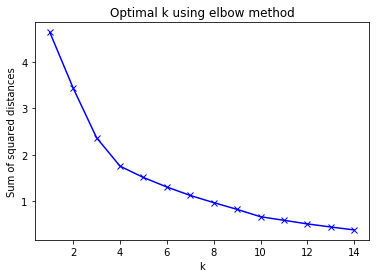

In [18]:
bvclustering_df = bvconehotgrp_df.drop('Name', 1)
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k,random_state=0)
    km = km.fit(bvclustering_df)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Optimal k using elbow method')
plt.show()

Using the optimal value of k=8 for the K-Means Algorithm the cluster labels are obatained for each venue that this is then appended to the dataset containing the probabilities of occurence of each offense in vicinity of a given venues

In [19]:
kclusters = 8
# run k-means clustering for k=8
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(bvclustering_df)
bvconehotgrp_df.insert(0, 'Cluster Labels', kmeans.labels_)

Merge the resulting dataset with the boston venues dataset to get a final data set 

In [20]:
bvmerged_df = bv_df
bvmerged_df = bvmerged_df.join(bvconehotgrp_df.set_index('Name'), on='Name')

bvmerged_df.head() 

Name            Category   Latitude  Longitude  \
0            North End Park                Park  42.362488 -71.056477   
1             Quincy Market       Historic Site  42.360095 -71.054730   
2  Faneuil Hall Marketplace       Historic Site  42.359978 -71.056410   
3            Sam LaGrassa's      Sandwich Place  42.356870 -71.059960   
4           Saus Restaurant  Belgian Restaurant  42.361076 -71.057054   

   Cluster Labels  Aggravated Assault  Arson  \
0               4            0.071429    0.0   
1               4            0.044554    0.0   
2               4            0.049793    0.0   
3               4            0.029630    0.0   
4               4            0.066667    0.0   

   Assembly or Gathering Violations  Auto Theft  Bomb Hoax  \
0                          0.004464    0.008929   0.004464   
1                          0.004950    0.014851   0.004950   
2                          0.004149    0.004149   0.004149   
3                          0.003704    0.003704   0.003704   
4                          0.004167    0.008333   0.004167   

   Commercial Burglary  Confidence Games  Counterfeiting  Disorderly Conduct  \
0             0.013393          0.008929        0.000000            0.040179   
1             0.004950          0.014851        0.000000            0.054455   
2             0.012448          0.004149        0.000000            0.045643   
3             0.007407          0.025926        0.003704            0.033333   
4             0.012500          0.004167        0.000000            0.054167   

   Drug Violation  Embezzlement  Evading Fare  Fire Related Reports  \
0        0.093750           0.0           0.0              0.008929   
1        0.094059           0.0           0.0              0.009901   
2        0.070539           0.0           0.0              0.008299   
3        0.055556           0.0           0.0              0.003704   
4        0.083333           0.0           0.0              0.008333   

   Firearm Discovery  Firearm Violations     Fraud  Harassment  \
0           0.004464            0.008929  0.049107    0.022321   
1           0.004950            0.004950  0.044554    0.004950   
2           0.004149            0.004149  0.049793    0.024896   
3           0.000000            0.011111  0.025926    0.007407   
4           0.004167            0.004167  0.050000    0.025000   

   Harbor Related Incidents   Larceny  Larceny From Motor Vehicle  \
0                  0.004464  0.236607                    0.008929   
1                  0.004950  0.242574                    0.009901   
2                  0.004149  0.248963                    0.008299   
3                  0.000000  0.300000                    0.007407   
4                  0.004167  0.208333                    0.008333   

   License Violation  Liquor Violation  None  Offenses Against Child / Family  \
0           0.026786          0.004464   0.0                              0.0   
1           0.024752          0.000000   0.0                              0.0   
2           0.020747          0.000000   0.0                              0.0   
3           0.018519          0.011111   0.0                              0.0   
4           0.025000          0.004167   0.0                              0.0   

   Other Burglary  Prisoner Related Incidents  Property Lost  \
0        0.004464                    0.004464       0.116071   
1        0.004950                    0.004950       0.138614   
2        0.004149                    0.004149       0.149378   
3        0.003704                    0.003704       0.125926   
4        0.004167                    0.004167       0.137500   

   Property Related Damage  Residential Burglary  \
0                 0.004464              0.004464   
1                 0.000000              0.009901   
2                 0.000000              0.008299   
3                 0.000000              0.000000   
4                 0.004167              0.004167   

   Restraining Or

## 4. Results and discussion

To understand the results lets visualize them by plotting the average probabilities of occurrence of a given offense in a given cluster

In [21]:
def plotCrimeIncidentsProbability(df,probStringIndex):
    probString = {}
    dict=df.mean(axis=0).to_dict()
    for key,val in sorted(dict.items(), key=operator.itemgetter(1), reverse=True)[:2]:
        probString.update({key: '{}%'.format(round(val*100, 2))})
    probString = ','.join(["{}:{}".format(*i) for i in probString.items()])
    probStrings.update({probStringIndex: probString})
   
    
    dict_df  = pd.DataFrame(dict, index=[0])
    objects = list(dict_df.columns.values)
    y_pos = np.arange(len(objects))
    performance = dict_df.iloc[0]

    plt.figure(figsize=(15,5))
    plt.bar(y_pos, performance, align='center', alpha=0.5)
    plt.xticks(y_pos, objects, rotation=90)
    plt.ylabel('Probability')
    plt.title('Average Offense Probability of Cluster {}'.format(probStringIndex+1))
 
    plt.show()
    print('Number of venues in cluster: {}'.format(df.shape[0]))
    print('Most prominently expected offenses in this cluster of venues: {}'.format(probString if 'None' not in probString else 'None'))
    probStringIndex += 1
    return probStringIndex

In [22]:
probStrings = {}
probStringIndex = 0

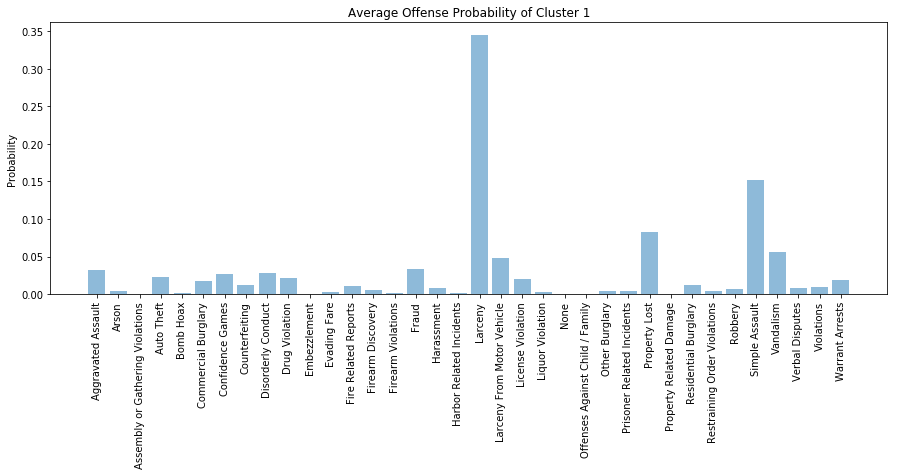

Number of venues in cluster: 21
Most prominently expected offenses in this cluster of venues: Larceny:34.48%,Simple Assault:15.17%


In [23]:
probStringIndex = plotCrimeIncidentsProbability(bvmerged_df.loc[bvmerged_df['Cluster Labels'] == 0, bvmerged_df.columns[list(range(5, bvmerged_df.shape[1]))]],probStringIndex)

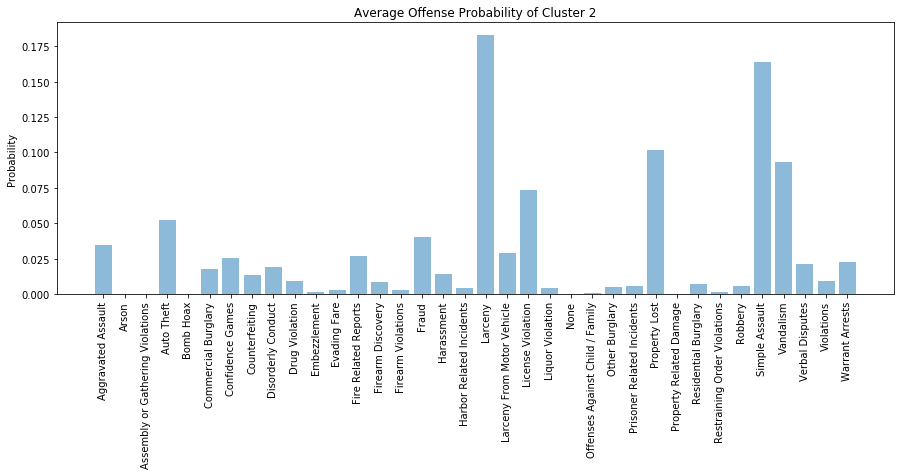

Number of venues in cluster: 14
Most prominently expected offenses in this cluster of venues: Larceny:18.28%,Simple Assault:16.37%


In [24]:
probStringIndex = plotCrimeIncidentsProbability(bvmerged_df.loc[bvmerged_df['Cluster Labels'] == 1, bvmerged_df.columns[list(range(5, bvmerged_df.shape[1]))]],probStringIndex)

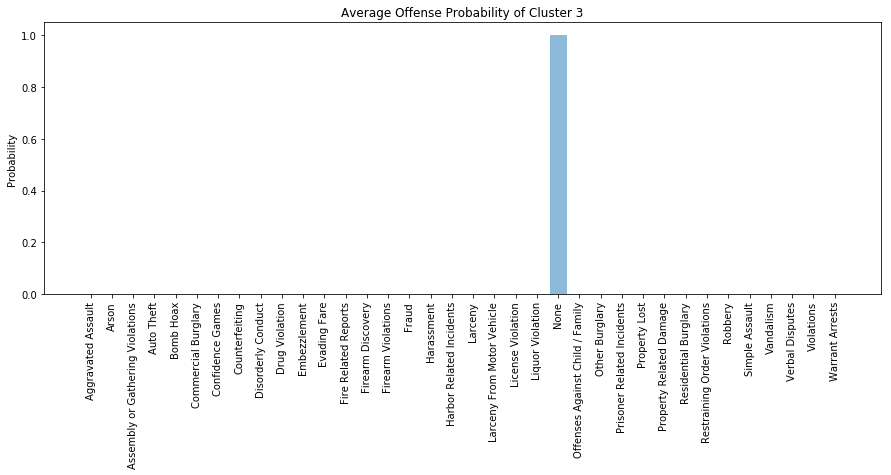

Number of venues in cluster: 1
Most prominently expected offenses in this cluster of venues: None


In [25]:
probStringIndex = plotCrimeIncidentsProbability(bvmerged_df.loc[bvmerged_df['Cluster Labels'] == 2, bvmerged_df.columns[list(range(5, bvmerged_df.shape[1]))]],probStringIndex)

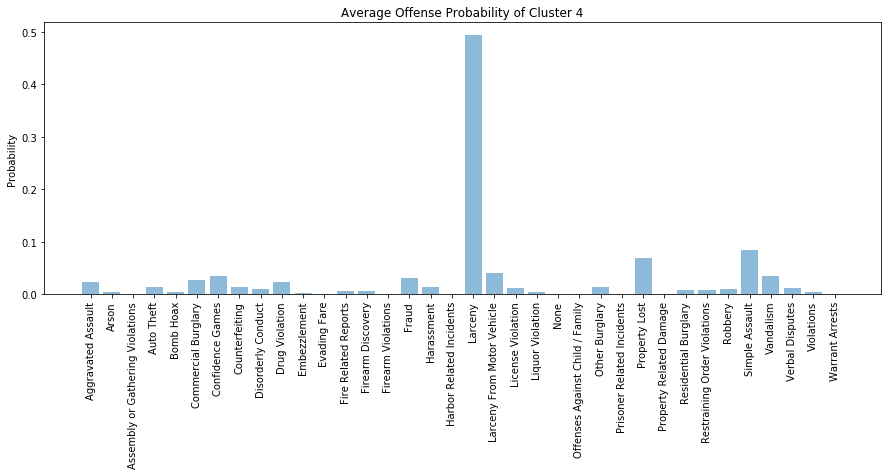

Number of venues in cluster: 15
Most prominently expected offenses in this cluster of venues: Larceny:49.35%,Simple Assault:8.37%


In [26]:
probStringIndex = plotCrimeIncidentsProbability(bvmerged_df.loc[bvmerged_df['Cluster Labels'] == 3, bvmerged_df.columns[list(range(5, bvmerged_df.shape[1]))]],probStringIndex)

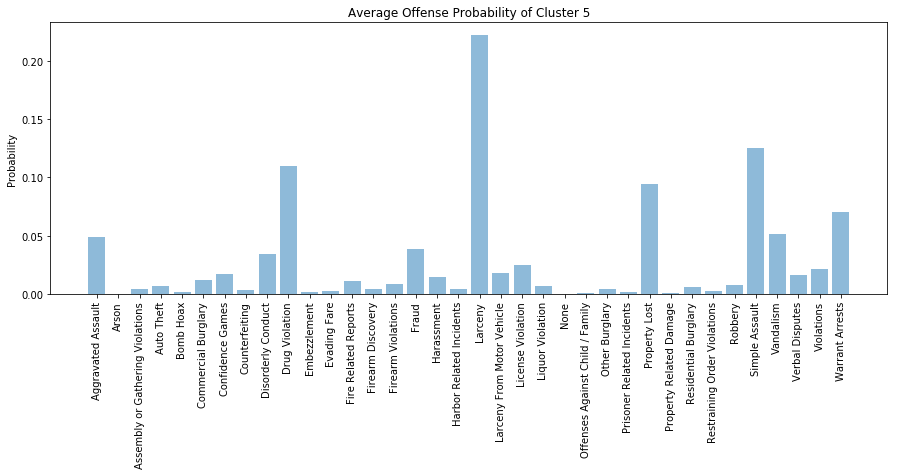

Number of venues in cluster: 36
Most prominently expected offenses in this cluster of venues: Larceny:22.18%,Simple Assault:12.51%


In [27]:
probStringIndex = plotCrimeIncidentsProbability(bvmerged_df.loc[bvmerged_df['Cluster Labels'] == 4, bvmerged_df.columns[list(range(5, bvmerged_df.shape[1]))]],probStringIndex)

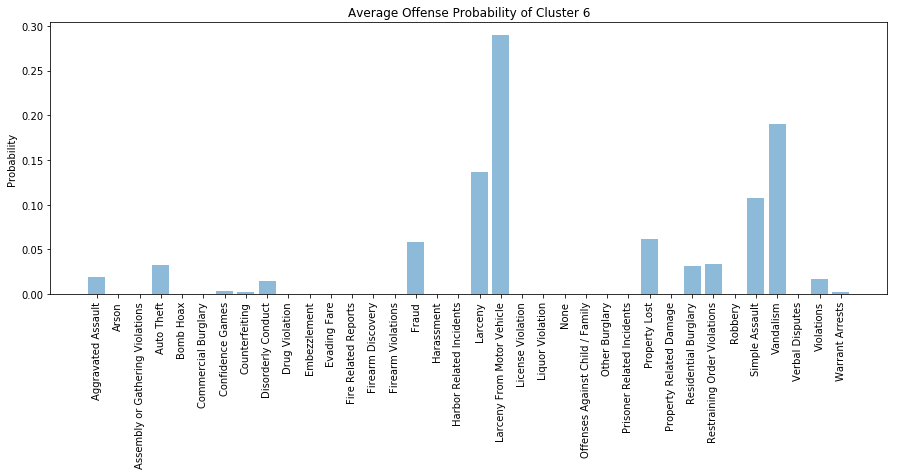

Number of venues in cluster: 6
Most prominently expected offenses in this cluster of venues: Larceny From Motor Vehicle:28.95%,Vandalism:19.03%


In [28]:
probStringIndex = plotCrimeIncidentsProbability(bvmerged_df.loc[bvmerged_df['Cluster Labels'] == 5, bvmerged_df.columns[list(range(5, bvmerged_df.shape[1]))]],probStringIndex)

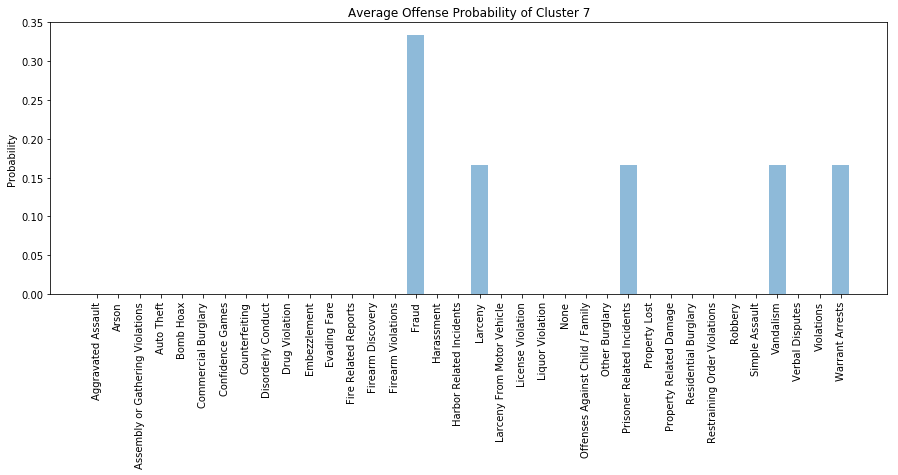

Number of venues in cluster: 1
Most prominently expected offenses in this cluster of venues: Fraud:33.33%,Vandalism:16.67%


In [29]:
probStringIndex = plotCrimeIncidentsProbability(bvmerged_df.loc[bvmerged_df['Cluster Labels'] == 6, bvmerged_df.columns[list(range(5, bvmerged_df.shape[1]))]],probStringIndex)

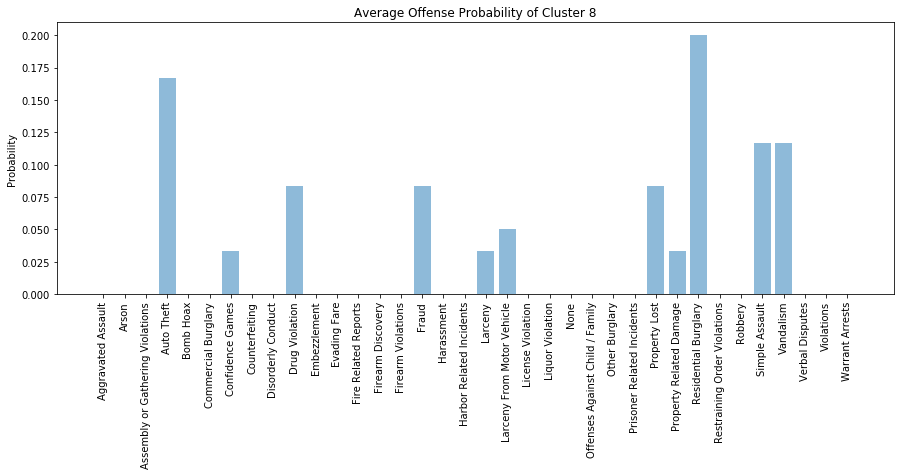

Number of venues in cluster: 2
Most prominently expected offenses in this cluster of venues: Auto Theft:16.67%,Residential Burglary:20.0%


In [30]:
probStringIndex = plotCrimeIncidentsProbability(bvmerged_df.loc[bvmerged_df['Cluster Labels'] == 7, bvmerged_df.columns[list(range(5, bvmerged_df.shape[1]))]],probStringIndex)

On observing the plots above we are able to identify the distribution of average probabilities of offenses in a given a cluster of venues. The prominent offense types are distinctly visible in most cases. It is important to pay attention to value of mean probabilities of offenses types in the cluster. In some cases the distribution is spread out but the mean values are small whereas in others the distribution is more concentrated and the probabilities are high. It would be beneficial to think of venues in clusters with low probabilities of offenses as safer compared to the ones that have high probabilities. Even a couple of high probabilities of offenses in a cluster would suggest that they are more unsafe as compared to venues in other clusters where the distribution is spread out but the average probabilities of offenses are low, though it is important to qualitatively understand the offense type and its weightage. Say for example, a small probability of an aggravated assault offense type is potentially more than a considerable probability value of Liquor Violation. Identifying high concertation of offense probabilities also is useful for law enforcement agencies to concrete their efforts in tackling these offenses. Apart from this the cluster of venues observed here are also found to be geographically clustered when observed on a map, indicating a relation of offense types to the geographical locations. 

It would be necessary to understand that we have considered the dataset which is has more recent records. Now, sometimes it also useful to consider the data that is more post dated as offenses at a given location also tend to also follow a pattern in time, but the choice of time in selecting the records in crime incident dataset depends on what one is trying to accomplish. In our cases we were interested in most recent trends and therefore selected crime incidents that occurred in recent past. The offense types that we considered important were selected and others were dropped again this was an arbitrary choice. One can limit this selection of offense types for instance if one is looking for only more heinous crimes types the offense type feature would have fewer values. Venue dataset too is limited by the account type used to access the API whereas some information (nearly 5-10%) from crime incidents dataset is lost because of the unavailability of latitude and longitude co-ordinates or their incorrect values. The results obtained therefore must be looked at after accounting in all such factors.

In the end though, we could reasonably well answer the question that we posed before us as we embarked on the analysis: How safe are we when we visit one of the popular venues in the town? Merely now looking at the cluster in which this venue lies we can easily identify the two most prominent offense types in vicinity of such venue. We can further drill down to identify other offense types that are expected by looking at the distribution of offense types of the cluster. Somebody looking to start say a new restaurant in vicinity of a venue can now be more mindful of how safe the neighborhood is and what is expected.

## 5. Conclusion

Let us conclude the analysis by plotting the clustered venues on the map of Boston, MA where different clusters of venues are color coded indicating the similarity of the offences that are expected to occur in their vicinity. The marker for each venue shows the probabilities of two most common offences that is expected to occur around them based on average probabilities of crime incidents in the cluster. The venues are overlayed on the crime map of Boston to give more correct and exact idea of the offense that occurred in vicinity of the venue along with its place and date of occurrence

In [31]:
# create the map of Boston 
map_boston = folium.Map(location=[latitude, longitude], zoom_start=15)

# add crime incidents markers to map
for lat, lng, offense, street, date in zip(bostonCIGeo_df['Latitude'], bostonCIGeo_df['Longitude'], bostonCIGeo_df['Offense'], bostonCIGeo_df['Street'], bostonCIGeo_df['Date']):
    label = '{} reported on {} at {}'.format(offense,street, date)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_boston)  
    

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.viridis(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add  venue markers to the map
markers_colors = []
for lat,lon,name,cat,cluster in zip(bvmerged_df['Latitude'], bvmerged_df['Longitude'],bvmerged_df['Name'], bvmerged_df['Category'], bvmerged_df['Cluster Labels']):
    offStr = list(probStrings.values())[cluster] if 'None' not in list(probStrings.values())[cluster] else 'None' 
    htmlLabel='<html><span style="text-decoration: underline;">Category:</span> '+ str(cat)+', <span style="text-decoration: underline;">Name:</span> '+  str(name) + '<hr ><span style="font-style:italic;font-size:x-small">Expected Offense:'+ offStr + '</span></html>'
    iframe = IFrame(html=htmlLabel, width=350, height=90)
    popup = folium.Popup(iframe, max_width=2650)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=popup,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_boston)
       
map_boston
